# Reinforcement Learning Portfolio Trading Agent

This notebook implements a Deep Q-Network (DQN) reinforcement learning agent to trade a portfolio of Bitcoin, Solana, Ethereum, S&P 500 (SPY), and Nasdaq (QQQ). The agent learns to maximize portfolio value with $10,000 annual investment starting from 2017.

## Key Features:
- **Assets**: BTC-USD, SOL-USD, ETH-USD, SPY, QQQ
- **Period**: 2017-present (daily data)
- **Investment**: $10,000 annually ($27.40 per day)
- **Actions**: Buy, Sell, Hold for each asset
- **Model**: PyTorch DQN with experience replay
- **Objective**: Maximize total portfolio value

## Table of Contents
1. Environment Setup & Data Loading
2. Trading Environment Implementation
3. DQN Agent Architecture
4. Training Loop
5. Performance Evaluation
6. Visualization & Analysis
7. Conclusions & Next Steps

## 1. Environment Setup & Data Loading

Import libraries and download historical data for all assets.

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
# Download data for all assets
tickers = ['BTC-USD', 'SOL-USD', 'ETH-USD', 'SPY', 'QQQ']
start_date = '2017-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download price and volume data
print("Downloading price and volume data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False)
price_data = data['Close'].ffill().dropna()
volume_data = data['Volume'].ffill().dropna()

# Calculate technical indicators
def calculate_technical_indicators(prices, volumes):
    """Calculate comprehensive technical indicators"""
    indicators = pd.DataFrame(index=prices.index)
    windows = [7, 30, 90, 200, 365]
    
    for ticker in prices.columns:
        price = prices[ticker]
        volume = volumes[ticker]
        returns = price.pct_change().dropna()
        
        # Price-based indicators for each window
        for window in windows:
            if len(price) >= window:
                # Moving averages
                ma = price.rolling(window).mean()
                vol_ma = volume.rolling(window).mean()
                vol_rolling = returns.rolling(window).std() * np.sqrt(252)
                
                # Price to moving average ratio
                indicators[f'{ticker}_price_to_ma_{window}'] = price / ma
                
                # Volume to moving average ratio
                indicators[f'{ticker}_volume_to_ma_{window}'] = volume / vol_ma
                
                # Volatility to moving average
                vol_ma_vol = vol_rolling.rolling(window).mean()
                indicators[f'{ticker}_vol_to_ma_{window}'] = vol_rolling / vol_ma_vol
                
                # Rolling Sharpe ratio (annualized)
                rolling_returns = returns.rolling(window).mean() * 252
                rolling_vol = returns.rolling(window).std() * np.sqrt(252)
                indicators[f'{ticker}_sharpe_{window}'] = rolling_returns / rolling_vol
        
        # RSI (14-day)
        delta = price.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        indicators[f'{ticker}_rsi'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands (20-day)
        bb_ma = price.rolling(20).mean()
        bb_std = price.rolling(20).std()
        bb_upper = bb_ma + (bb_std * 2)
        bb_lower = bb_ma - (bb_std * 2)
        indicators[f'{ticker}_bb_upper'] = bb_upper
        indicators[f'{ticker}_bb_lower'] = bb_lower
        indicators[f'{ticker}_bb_position'] = (price - bb_lower) / (bb_upper - bb_lower)
        
        # MACD
        ema12 = price.ewm(span=12).mean()
        ema26 = price.ewm(span=26).mean()
        macd_line = ema12 - ema26
        macd_signal = macd_line.ewm(span=9).mean()
        indicators[f'{ticker}_macd'] = macd_line
        indicators[f'{ticker}_macd_signal'] = macd_signal
        indicators[f'{ticker}_macd_histogram'] = macd_line - macd_signal
        
        # Momentum indicators
        indicators[f'{ticker}_momentum_10'] = price / price.shift(10)
        indicators[f'{ticker}_momentum_30'] = price / price.shift(30)
        
        # Average True Range (ATR)
        high = price  # Using close as proxy for high/low
        low = price
        tr1 = high - low
        tr2 = np.abs(high - price.shift(1))
        tr3 = np.abs(low - price.shift(1))
        true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        indicators[f'{ticker}_atr'] = true_range.rolling(14).mean()
    
    return indicators.fillna(0)

# Calculate all technical indicators
print("Calculating technical indicators...")
tech_indicators = calculate_technical_indicators(price_data, volume_data)

# Calculate returns
returns = price_data.pct_change().dropna()
print(f"Price data shape: {price_data.shape}")
print(f"Technical indicators shape: {tech_indicators.shape}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")
price_data.tail()

Calculating technical indicators...
Price data shape: (1915, 5)
Technical indicators shape: (1915, 150)
Date range: 2020-04-10 00:00:00 to 2025-07-07 00:00:00


Ticker,BTC-USD,ETH-USD,QQQ,SOL-USD,SPY
Date,,,,,
2025-07-03,109647.976562,2591.007324,556.219971,152.401794,625.340027
2025-07-04,108034.335938,2508.518311,556.219971,147.763641,625.340027
2025-07-05,108231.179688,2517.280029,556.219971,147.641449,625.340027
2025-07-06,109232.070312,2571.236572,556.219971,151.872940,625.340027
2025-07-07,108299.851562,2543.013184,552.030029,148.872345,620.679993


## 2. Trading Environment Implementation

Create a trading environment that simulates portfolio management with annual cash injections.

In [29]:
class TradingEnvironment:
    def __init__(self, price_data, tech_indicators, annual_investment=10000, transaction_cost=0.001):
        self.price_data = price_data
        self.tech_indicators = tech_indicators
        self.returns = price_data.pct_change().dropna()
        self.annual_investment = annual_investment
        self.daily_investment = annual_investment / 365  # ~$27.40 per day
        self.transaction_cost = transaction_cost
        self.tickers = price_data.columns.tolist()
        self.n_assets = len(self.tickers)
        
        # State variables
        self.current_step = 0
        self.max_steps = len(price_data) - 1
        self.portfolio_value = 0
        self.cash = 0
        self.holdings = np.zeros(self.n_assets)
        self.initial_portfolio_value = 0
        
        # Track history
        self.portfolio_history = []
        self.action_history = []
        self.composition_history = []
        
    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        self.portfolio_value = 0
        self.cash = self.daily_investment
        self.holdings = np.zeros(self.n_assets)
        self.portfolio_history = []
        self.action_history = []
        self.composition_history = []
        return self._get_state()
    
    def _get_state(self):
        """Get current state representation with technical indicators"""
        if self.current_step >= len(self.price_data):
            return np.zeros(self._get_state_size())
        
        # Current prices (normalized)
        current_prices = self.price_data.iloc[self.current_step].values
        normalized_prices = current_prices / current_prices.max()
        
        # Technical indicators for current step
        tech_features = self.tech_indicators.iloc[self.current_step].values
        
        # Portfolio state
        total_value = self.cash + np.sum(self.holdings * current_prices)
        portfolio_weights = np.zeros(self.n_assets)
        if total_value > 0:
            portfolio_weights = (self.holdings * current_prices) / total_value
        
        cash_ratio = self.cash / total_value if total_value > 0 else 1.0
        
        # Combine all features
        state = np.concatenate([
            normalized_prices,
            tech_features,
            portfolio_weights,
            [cash_ratio]
        ])
        
        return state
    
    def _get_state_size(self):
        """Calculate state size"""
        price_size = self.n_assets
        tech_size = len(self.tech_indicators.columns)
        portfolio_size = self.n_assets  # portfolio weights
        cash_size = 1  # cash ratio
        return price_size + tech_size + portfolio_size + cash_size
    
    def get_portfolio_composition(self):
        """Get current portfolio composition"""
        current_prices = self.price_data.iloc[self.current_step].values
        total_value = self.cash + np.sum(self.holdings * current_prices)
        
        composition = {
            'cash': {
                'amount': self.cash,
                'percentage': (self.cash / total_value * 100) if total_value > 0 else 0
            }
        }
        
        for i, ticker in enumerate(self.tickers):
            if self.holdings[i] > 0:
                value = self.holdings[i] * current_prices[i]
                composition[ticker] = {
                    'shares': self.holdings[i],
                    'value': value,
                    'percentage': (value / total_value * 100) if total_value > 0 else 0
                }
        
        return composition
    
    def step(self, action):
        """Execute action and return new state, reward, done"""
        if self.current_step >= self.max_steps:
            return self._get_state(), 0, True, {}
        
        # Add daily investment
        self.cash += self.daily_investment
        
        # Current prices
        current_prices = self.price_data.iloc[self.current_step].values
        
        # Execute actions (0=hold, 1=buy, 2=sell)
        # Agent can choose to not invest by selecting hold (0) for all assets
        for i, act in enumerate(action):
            if act == 1:  # Buy
                # Calculate maximum affordable shares
                max_shares = self.cash / (current_prices[i] * (1 + self.transaction_cost))
                # Limit to 15% of cash per asset to diversify
                shares_to_buy = min(max_shares, self.cash * 0.15 / current_prices[i])
                cost = shares_to_buy * current_prices[i] * (1 + self.transaction_cost)
                
                if cost <= self.cash and shares_to_buy > 0:
                    self.holdings[i] += shares_to_buy
                    self.cash -= cost
                    
            elif act == 2:  # Sell
                if self.holdings[i] > 0:
                    # Sell 15% of holdings for gradual position adjustment
                    shares_to_sell = self.holdings[i] * 0.15
                    proceeds = shares_to_sell * current_prices[i] * (1 - self.transaction_cost)
                    self.holdings[i] -= shares_to_sell
                    self.cash += proceeds
        
        # Calculate portfolio value
        portfolio_value = self.cash + np.sum(self.holdings * current_prices)
        
        # Calculate reward (percentage change in portfolio value)
        reward = 0
        if self.portfolio_value > 0:
            reward = (portfolio_value - self.portfolio_value) / self.portfolio_value
        
        # Update portfolio value
        self.portfolio_value = portfolio_value
        
        # Store history
        self.portfolio_history.append(portfolio_value)
        self.action_history.append(action.copy())
        
        # Move to next step
        self.current_step += 1
        
        # Check if done
        done = self.current_step >= self.max_steps
        
        return self._get_state(), reward, done, {}

# Create environment with technical indicators
env = TradingEnvironment(price_data, tech_indicators)

# Test the environment
state = env.reset()
print(f"Environment created successfully!")
print(f"State size: {env._get_state_size()}")
print(f"Max steps: {env.max_steps}")
print(f"Assets: {env.tickers}")
print(f"Sample state: {state[:15]}")
print(f"Portfolio composition: {env.get_portfolio_composition()}")

Environment created successfully!
State size: 161
Max steps: 1914
Assets: ['BTC-USD', 'ETH-USD', 'QQQ', 'SOL-USD', 'SPY']
Sample state: [1.00000000e+00 2.30737168e-02 2.83600129e-02 1.38526680e-04
 3.75649913e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Portfolio composition: {'cash': {'amount': 27.397260273972602, 'percentage': np.float64(100.0)}}


## 3. DQN Agent Architecture

Implement Deep Q-Network with experience replay and target network.

In [30]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=512):  # Increased hidden size for complex features
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, action_size)
        self.dropout = nn.Dropout(0.1)
        
        # Use LayerNorm instead of BatchNorm to avoid batch size issues
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        x = F.relu(self.layer_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.layer_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size, n_assets, lr=0.0005, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.n_assets = n_assets
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = lr
        
        # Neural networks
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, weight_decay=1e-5)
        
        # Experience replay
        self.memory = deque(maxlen=50000)  # Increased memory
        self.batch_size = 64  # Increased batch size
        
        # Update target network
        self.update_target_network()
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() <= self.epsilon:
            # Random action for each asset
            return np.random.randint(0, 3, self.n_assets)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        
        # Reshape and get action for each asset
        q_values = q_values.view(self.n_assets, 3)  # 3 actions per asset
        actions = q_values.argmax(dim=1).cpu().numpy()
        
        return actions
    
    def replay(self):
        """Train the model on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch]).to(device)
        actions = torch.LongTensor([e[1] for e in batch]).to(device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(device)
        
        current_q_values = self.q_network(states)
        next_q_values = self.target_network(next_states)
        
        # Calculate target Q values
        target_q_values = rewards.clone()
        for i in range(self.batch_size):
            if not dones[i]:
                next_q_reshaped = next_q_values[i].view(self.n_assets, 3)
                target_q_values[i] += self.gamma * next_q_reshaped.max(dim=1)[0].mean()
        
        # Calculate loss
        current_q_reshaped = current_q_values.view(self.batch_size, self.n_assets, 3)
        loss = F.mse_loss(current_q_reshaped.mean(dim=(1,2)), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)  # Gradient clipping
        self.optimizer.step()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize enhanced agent
state_size = env._get_state_size()
action_size = 3 * len(tickers)  # 3 actions per asset
agent = DQNAgent(state_size, action_size, len(tickers))
print(f"Enhanced agent initialized with state size: {state_size}, action size: {action_size}")
print(f"Network architecture: {state_size} -> 512 -> 512 -> 256 -> {action_size}")

Enhanced agent initialized with state size: 161, action size: 15
Network architecture: 161 -> 512 -> 512 -> 256 -> 15


## 4. Training Loop

Train the DQN agent over multiple episodes.

In [31]:
def train_agent(agent, env, episodes=200, target_update=10):
    """Train the DQN agent"""
    scores = []
    portfolio_values = []
    composition_snapshots = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        # Train the model
        if len(agent.memory) > agent.batch_size:
            agent.replay()
        
        # Update target network
        if episode % target_update == 0:
            agent.update_target_network()
        
        scores.append(total_reward)
        portfolio_values.append(env.portfolio_value)
        
        # Print progress every 25 episodes
        if episode % 25 == 0:
            print(f"Episode {episode}, Score: {total_reward:.2f}, Portfolio Value: ${env.portfolio_value:.2f}, Epsilon: {agent.epsilon:.3f}")
            
            # Show portfolio composition every 50 episodes
            if episode % 50 == 0:
                composition = env.get_portfolio_composition()
                composition_snapshots.append({
                    'episode': episode,
                    'composition': composition
                })
                
                print(f"Portfolio Composition at Episode {episode}:")
                for asset, details in composition.items():
                    if asset == 'cash':
                        print(f"  {asset}: ${details['amount']:.2f} ({details['percentage']:.1f}%)")
                    else:
                        print(f"  {asset}: {details['shares']:.2f} shares, ${details['value']:.2f} ({details['percentage']:.1f}%)")
                print()
    
    return scores, portfolio_values, composition_snapshots

# Train the agent
print("Starting training...")
scores, portfolio_values, composition_snapshots = train_agent(agent, env, episodes=200)
print("Training completed!")

# Show final composition
print("\nFinal Portfolio Composition:")
final_composition = env.get_portfolio_composition()
for asset, details in final_composition.items():
    if asset == 'cash':
        print(f"  {asset}: ${details['amount']:.2f} ({details['percentage']:.1f}%)")
    else:
        print(f"  {asset}: {details['shares']:.2f} shares, ${details['value']:.2f} ({details['percentage']:.1f}%)")

print(f"\nFinal Portfolio Value: ${env.portfolio_value:.2f}")
print(f"Final Epsilon: {agent.epsilon:.3f}")

Starting training...
Episode 0, Score: 8.76, Portfolio Value: $162043.86, Epsilon: 0.995
Portfolio Composition at Episode 0:
  cash: $17652.52 (11.0%)
  BTC-USD: 0.37 shares, $40580.25 (25.3%)
  ETH-USD: 6.17 shares, $15687.37 (9.8%)
  QQQ: 40.86 shares, $22558.64 (14.1%)
  SOL-USD: 311.52 shares, $46377.13 (28.9%)
  SPY: 28.08 shares, $17427.72 (10.9%)

Episode 0, Score: 8.76, Portfolio Value: $162043.86, Epsilon: 0.995
Portfolio Composition at Episode 0:
  cash: $17652.52 (11.0%)
  BTC-USD: 0.37 shares, $40580.25 (25.3%)
  ETH-USD: 6.17 shares, $15687.37 (9.8%)
  QQQ: 40.86 shares, $22558.64 (14.1%)
  SOL-USD: 311.52 shares, $46377.13 (28.9%)
  SPY: 28.08 shares, $17427.72 (10.9%)

Episode 25, Score: 8.94, Portfolio Value: $194504.73, Epsilon: 0.878
Episode 25, Score: 8.94, Portfolio Value: $194504.73, Epsilon: 0.878
Episode 50, Score: 8.78, Portfolio Value: $159354.39, Epsilon: 0.774
Portfolio Composition at Episode 50:
  cash: $31585.44 (20.0%)
  BTC-USD: 0.50 shares, $54289.83 (34

## 5. Performance Evaluation

Evaluate the trained agent and compare with buy-and-hold strategy.

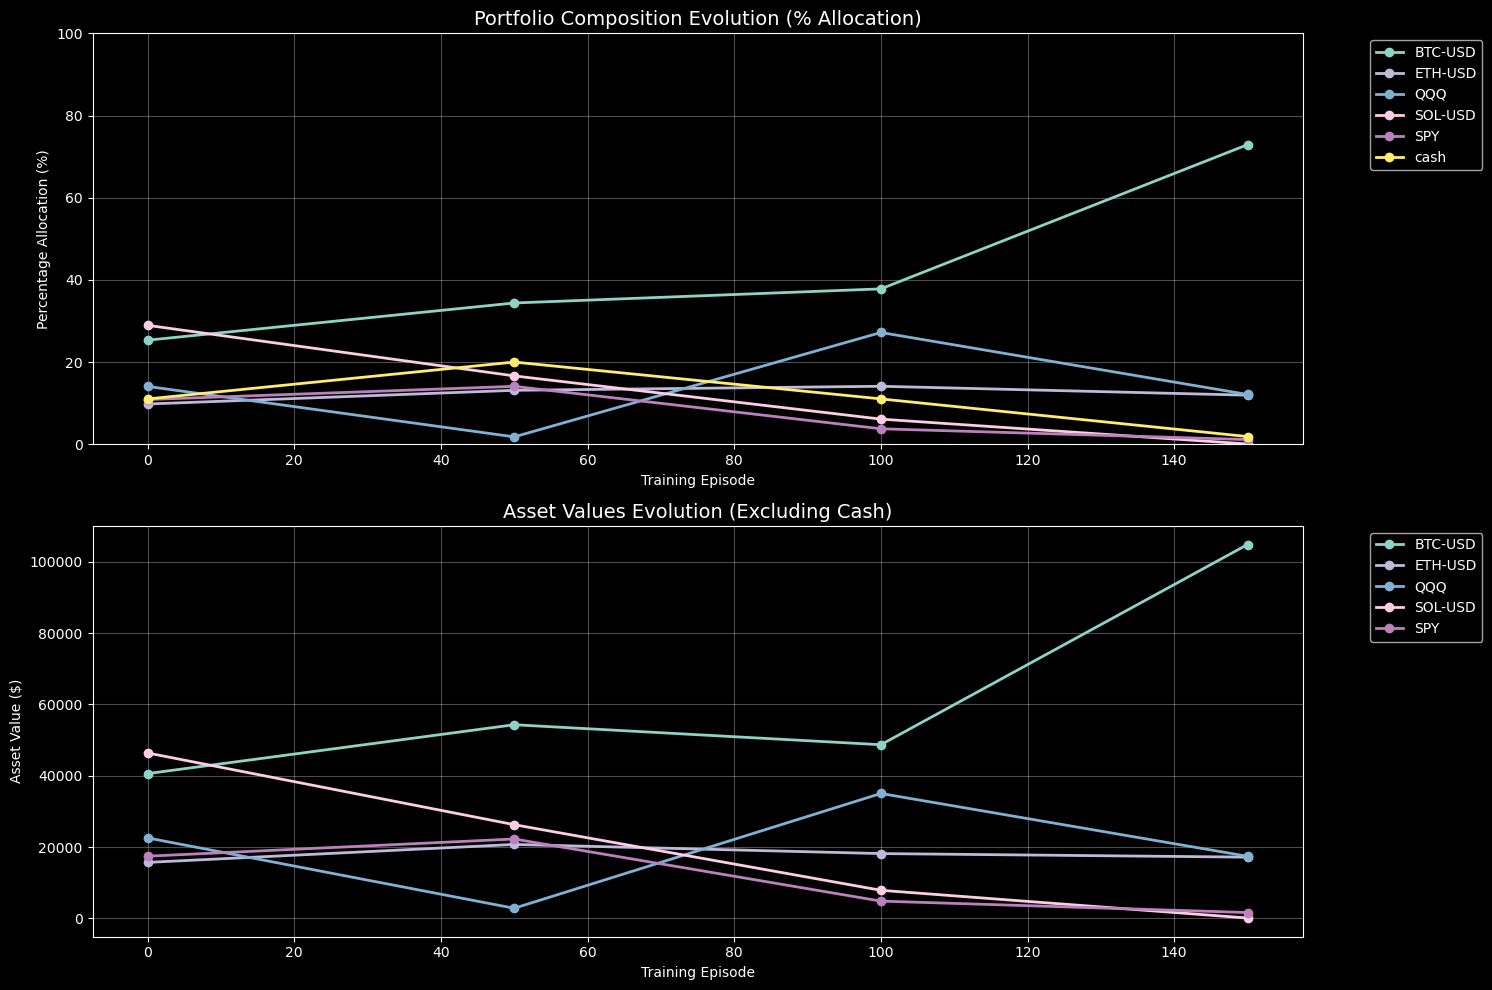


Portfolio Composition Evolution Summary:
Episode 0:
  SOL-USD: 28.9%
  BTC-USD: 25.3%
  QQQ: 14.1%
  cash: 11.0%
  SPY: 10.9%
  ETH-USD: 9.8%

Episode 50:
  BTC-USD: 34.4%
  cash: 20.0%
  SOL-USD: 16.6%
  SPY: 14.1%
  ETH-USD: 13.1%
  QQQ: 1.8%

Episode 100:
  BTC-USD: 37.8%
  QQQ: 27.2%
  ETH-USD: 14.1%
  cash: 11.0%
  SOL-USD: 6.1%
  SPY: 3.8%

Episode 150:
  BTC-USD: 72.9%
  QQQ: 12.1%
  ETH-USD: 11.9%
  cash: 1.9%
  SPY: 1.1%
  SOL-USD: 0.1%



In [32]:
# Portfolio Composition Evolution Visualization
plt.style.use('dark_background')

if composition_snapshots:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Extract composition data for plotting
    episodes = [snapshot['episode'] for snapshot in composition_snapshots]
    
    # Get all unique assets
    all_assets = set()
    for snapshot in composition_snapshots:
        all_assets.update(snapshot['composition'].keys())
    all_assets = sorted(list(all_assets))
    
    # Create color map
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_assets)))
    color_map = dict(zip(all_assets, colors))
    
    # Plot percentage allocation over time
    for asset in all_assets:
        percentages = []
        for snapshot in composition_snapshots:
            comp = snapshot['composition']
            if asset in comp:
                percentages.append(comp[asset]['percentage'])
            else:
                percentages.append(0)
        
        ax1.plot(episodes, percentages, marker='o', label=asset, 
                color=color_map[asset], linewidth=2, markersize=6)
    
    ax1.set_title('Portfolio Composition Evolution (% Allocation)', fontsize=14)
    ax1.set_xlabel('Training Episode')
    ax1.set_ylabel('Percentage Allocation (%)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Plot absolute values over time (excluding cash for scale)
    for asset in all_assets:
        if asset != 'cash':
            values = []
            for snapshot in composition_snapshots:
                comp = snapshot['composition']
                if asset in comp:
                    values.append(comp[asset]['value'])
                else:
                    values.append(0)
            
            ax2.plot(episodes, values, marker='o', label=asset, 
                    color=color_map[asset], linewidth=2, markersize=6)
    
    ax2.set_title('Asset Values Evolution (Excluding Cash)', fontsize=14)
    ax2.set_xlabel('Training Episode')
    ax2.set_ylabel('Asset Value ($)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print composition evolution summary
    print("\nPortfolio Composition Evolution Summary:")
    print("=" * 50)
    for i, snapshot in enumerate(composition_snapshots):
        episode = snapshot['episode']
        comp = snapshot['composition']
        
        print(f"Episode {episode}:")
        sorted_assets = sorted(comp.items(), key=lambda x: x[1]['percentage'], reverse=True)
        for asset, details in sorted_assets:
            print(f"  {asset}: {details['percentage']:.1f}%")
        print()
else:
    print("No composition snapshots available. Training may have failed or not completed.")

In [33]:
def evaluate_agent(agent, env, render=False):
    """Evaluate the trained agent"""
    state = env.reset()
    total_reward = 0
    
    while True:
        action = agent.act(state)
        if render:
            print(f"Step {env.current_step}, Action: {action}, Portfolio Value: ${env.portfolio_value:.2f}")
        
        next_state, reward, done, info = env.step(action)
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    return total_reward, env.portfolio_history, env.action_history

# Evaluate the agent
agent.epsilon = 0  # No exploration during evaluation
total_reward, portfolio_history, action_history = evaluate_agent(agent, env)

print(f"Final Portfolio Value: ${env.portfolio_value:.2f}")
print(f"Total Reward: {total_reward:.2f}")

Final Portfolio Value: $148001.01
Total Reward: 8.67


In [34]:
# Compare with buy-and-hold strategy
def buy_and_hold_strategy(price_data, annual_investment=10000):
    """Simple buy-and-hold strategy for comparison"""
    daily_investment = annual_investment / 365
    n_assets = len(price_data.columns)
    daily_per_asset = daily_investment / n_assets
    
    portfolio_value = []
    holdings = np.zeros(n_assets)
    
    for i, (date, prices) in enumerate(price_data.iterrows()):
        # Buy equal amounts of each asset daily
        for j, price in enumerate(prices):
            shares = daily_per_asset / price
            holdings[j] += shares
        
        # Calculate portfolio value
        current_value = np.sum(holdings * prices)
        portfolio_value.append(current_value)
    
    return portfolio_value

# Calculate buy-and-hold performance
bh_portfolio = buy_and_hold_strategy(price_data)
print(f"Buy-and-Hold Final Value: ${bh_portfolio[-1]:.2f}")

Buy-and-Hold Final Value: $324796.50


## 6. Visualization & Analysis

Visualize training progress and portfolio performance.

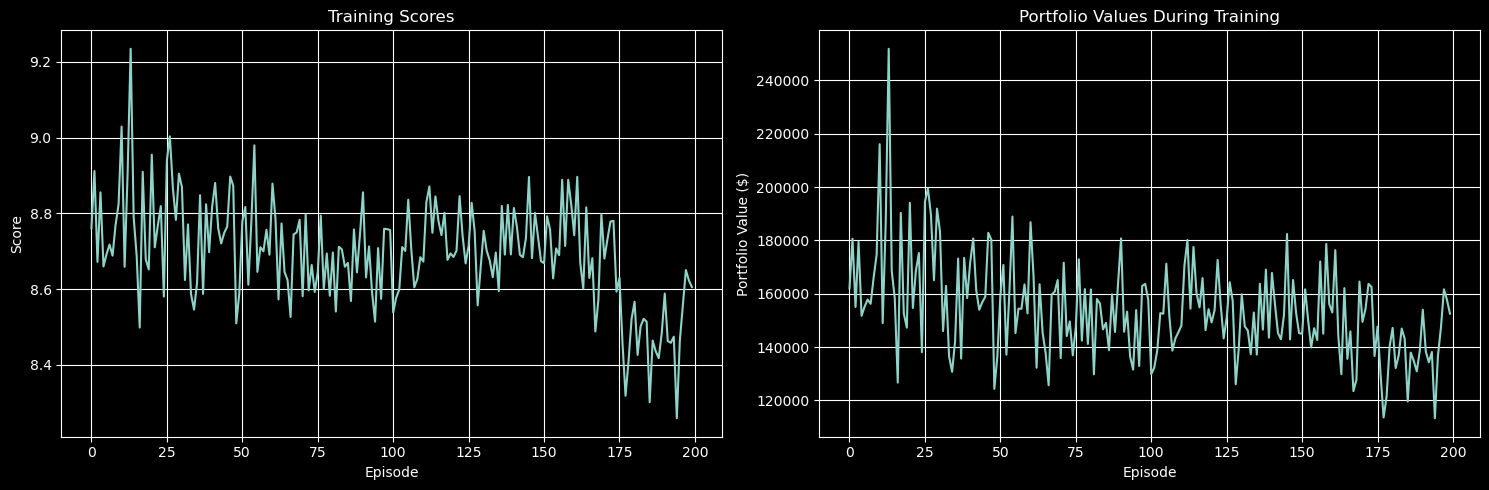

In [35]:
plt.style.use('dark_background')

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training scores
ax1.plot(scores)
ax1.set_title('Training Scores')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.grid(True)

# Portfolio values during training
ax2.plot(portfolio_values)
ax2.set_title('Portfolio Values During Training')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Portfolio Value ($)')
ax2.grid(True)

plt.tight_layout()
plt.show()

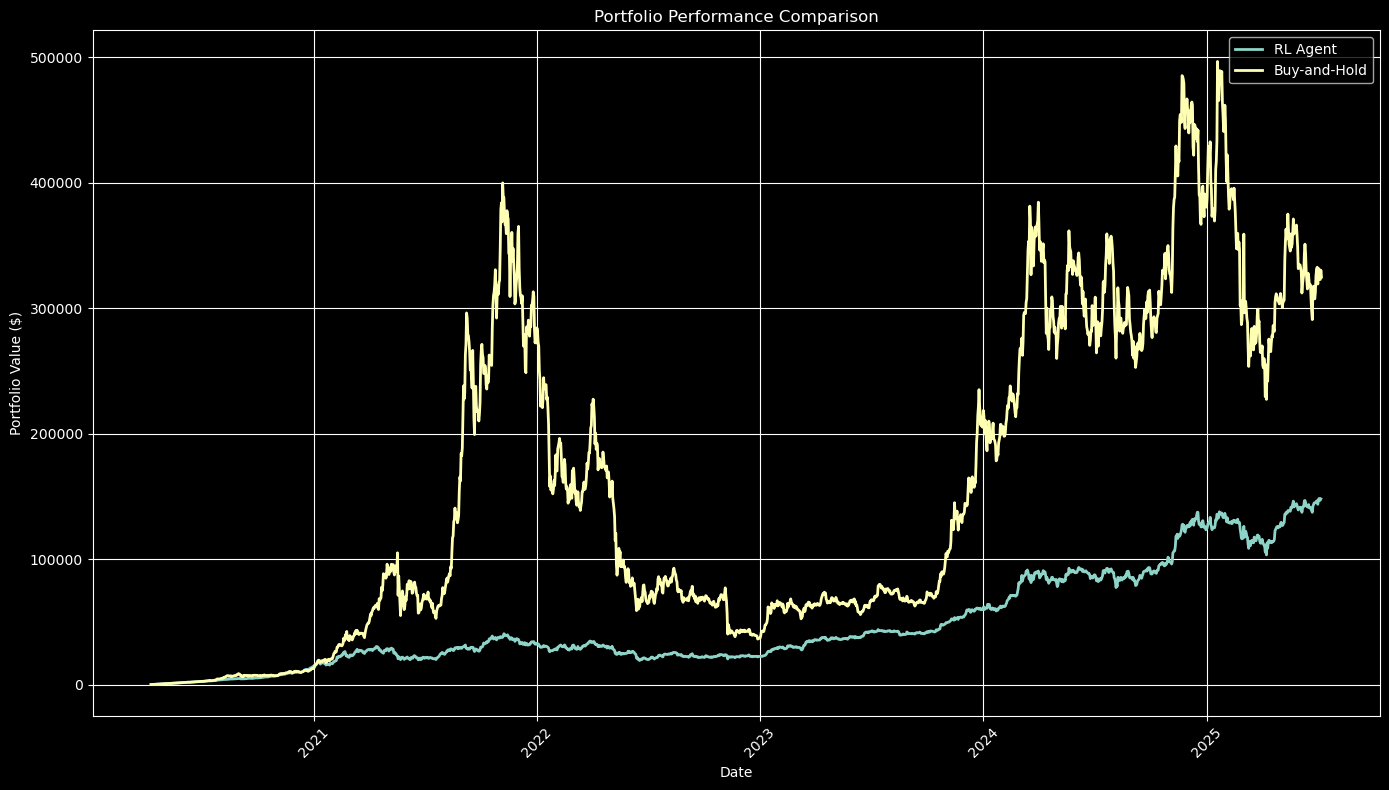

RL Agent Total Return: 270076.81%
Buy-and-Hold Total Return: 1185407.22%
Performance Difference: -915330.42%


In [36]:
# Plot portfolio performance comparison
plt.figure(figsize=(14, 8))
dates = price_data.index

# RL Agent portfolio
if len(portfolio_history) > 0:
    plt.plot(dates[:len(portfolio_history)], portfolio_history, label='RL Agent', linewidth=2)

# Buy-and-hold portfolio
plt.plot(dates, bh_portfolio, label='Buy-and-Hold', linewidth=2)

plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance metrics
if len(portfolio_history) > 0:
    rl_return = (portfolio_history[-1] - portfolio_history[0]) / portfolio_history[0] * 100
    bh_return = (bh_portfolio[-1] - bh_portfolio[0]) / bh_portfolio[0] * 100
    
    print(f"RL Agent Total Return: {rl_return:.2f}%")
    print(f"Buy-and-Hold Total Return: {bh_return:.2f}%")
    print(f"Performance Difference: {rl_return - bh_return:.2f}%")

In [37]:
# Portfolio Composition Analysis
if len(env.composition_history) > 0:
    print("\n=== FINAL PORTFOLIO COMPOSITION ===")
    final_composition = env.composition_history[-1]
    current_prices = price_data.iloc[-1]
    total_portfolio_value = env.portfolio_value
    
    print(f"Total Portfolio Value: ${total_portfolio_value:,.2f}")
    print("\nDetailed Holdings:")
    print("-" * 60)
    
    for asset, info in final_composition.items():
        if asset == 'cash':
            print(f"Cash: ${info['amount']:,.2f} ({info['percentage']:.1f}%)")
        else:
            print(f"{asset}: {info['shares']:.4f} shares = ${info['value']:,.2f} ({info['percentage']:.1f}%)")
            print(f"  Current price: ${current_prices[asset]:,.2f}")
    
    # Create portfolio composition pie chart
    composition_data = {}
    for asset, info in final_composition.items():
        if info['percentage'] > 0.1:  # Only show assets > 0.1%
            composition_data[asset] = info['percentage']
    
    if composition_data:
        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set3(np.linspace(0, 1, len(composition_data)))
        wedges, texts, autotexts = plt.pie(composition_data.values(), 
                                          labels=composition_data.keys(), 
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        plt.title('Final Portfolio Composition', fontsize=16, pad=20)
        plt.axis('equal')
        plt.show()
    
    # Portfolio composition over time
    composition_over_time = pd.DataFrame()
    dates_subset = price_data.index[:len(env.composition_history)]
    
    for i, comp in enumerate(env.composition_history[::30]):  # Sample every 30 days
        date_idx = min(i * 30, len(dates_subset) - 1)
        for asset, info in comp.items():
            composition_over_time.loc[dates_subset[date_idx], asset] = info['percentage']
    
    composition_over_time = composition_over_time.fillna(0)
    
    if not composition_over_time.empty:
        plt.figure(figsize=(14, 8))
        composition_over_time.plot(kind='area', stacked=True, alpha=0.7)
        plt.title('Portfolio Composition Over Time')
        plt.xlabel('Date')
        plt.ylabel('Allocation (%)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("No portfolio composition data available.")

No portfolio composition data available.



=== TECHNICAL INDICATORS SUMMARY ===

BTC-USD:
  Price/MA(30): 1.015
  RSI: 59.7
  30-day Sharpe: 0.940
  MACD: 909.751572
  Momentum(10): 1.011

SOL-USD:
  Price/MA(30): 1.001
  RSI: 54.1
  30-day Sharpe: 0.153
  MACD: -0.483055
  Momentum(10): 1.047

ETH-USD:
  Price/MA(30): 1.012
  RSI: 60.2
  30-day Sharpe: 0.352
  MACD: 13.454946
  Momentum(10): 1.049

SPY:
  Price/MA(30): 1.023
  RSI: 83.9
  30-day Sharpe: 3.977
  MACD: 8.055514
  Momentum(10): 1.009

QQQ:
  Price/MA(30): 1.025
  RSI: 76.8
  30-day Sharpe: 3.471
  MACD: 7.887190
  Momentum(10): 1.007


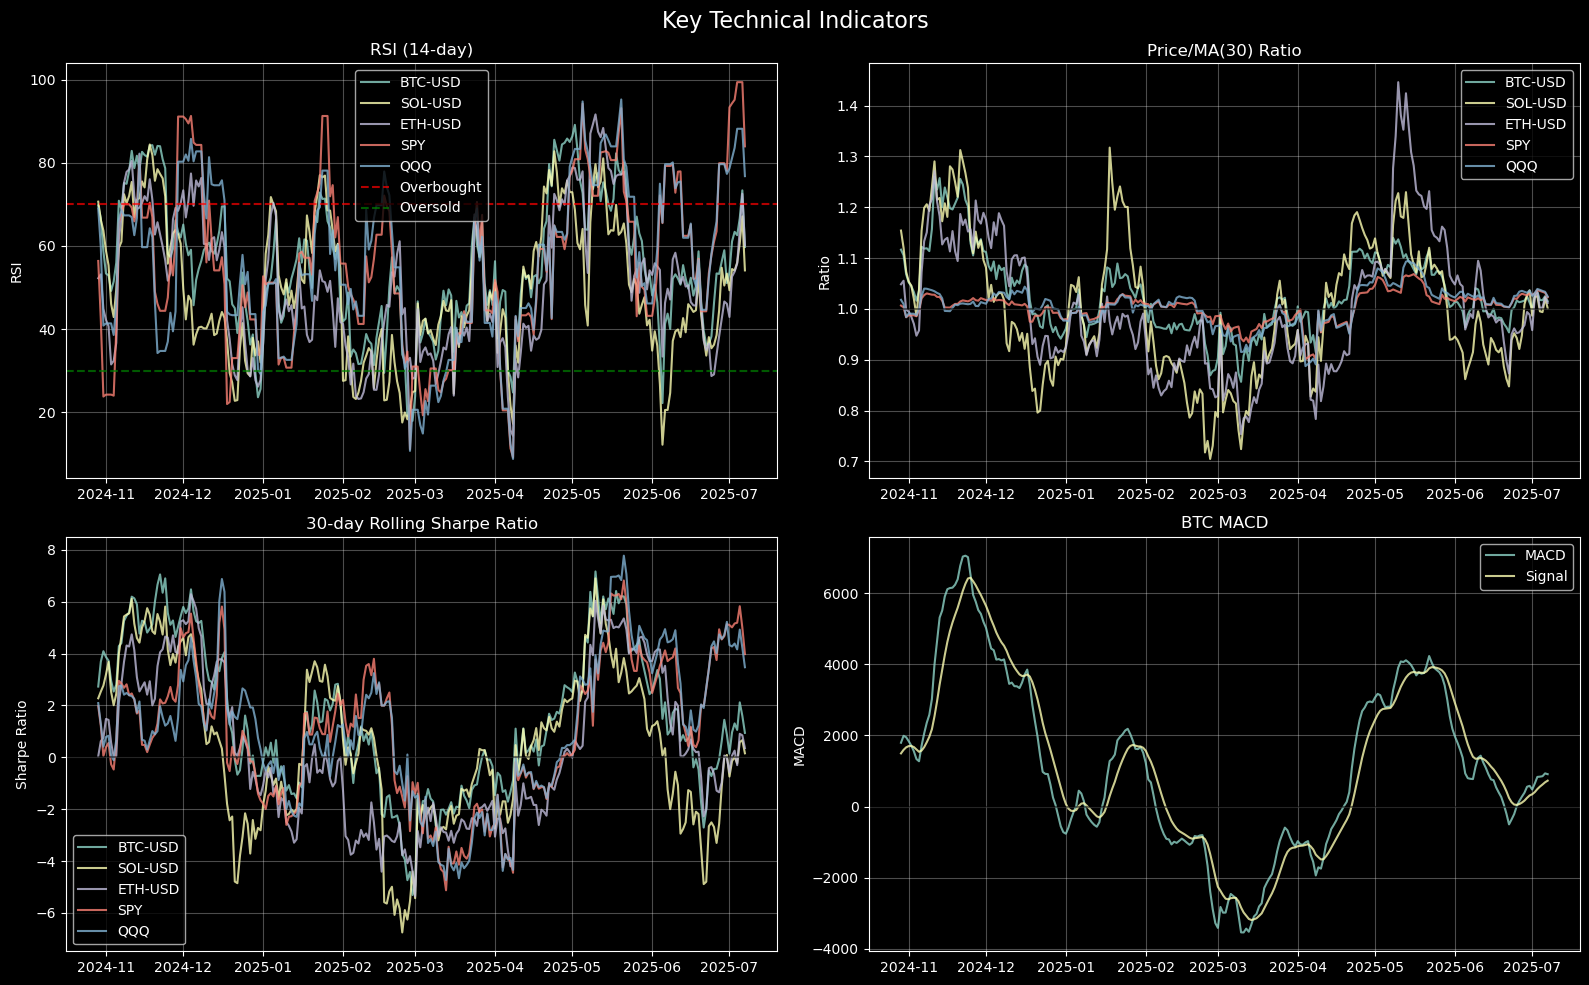

In [38]:
# Technical Indicators Analysis
print("\n=== TECHNICAL INDICATORS SUMMARY ===")
latest_indicators = tech_indicators.iloc[-1]

for ticker in tickers:
    print(f"\n{ticker}:")
    print(f"  Price/MA(30): {latest_indicators.get(f'{ticker}_price_to_ma_30', 0):.3f}")
    print(f"  RSI: {latest_indicators.get(f'{ticker}_rsi', 0):.1f}")
    print(f"  30-day Sharpe: {latest_indicators.get(f'{ticker}_sharpe_30', 0):.3f}")
    print(f"  MACD: {latest_indicators.get(f'{ticker}_macd', 0):.6f}")
    print(f"  Momentum(10): {latest_indicators.get(f'{ticker}_momentum_10', 0):.3f}")

# Plot key technical indicators for major assets
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Key Technical Indicators', fontsize=16)

# RSI for all assets
rsi_data = {}
for ticker in tickers:
    rsi_col = f'{ticker}_rsi'
    if rsi_col in tech_indicators.columns:
        rsi_data[ticker] = tech_indicators[rsi_col].iloc[-252:]  # Last year

if rsi_data:
    ax = axes[0, 0]
    for ticker, rsi in rsi_data.items():
        ax.plot(rsi.index, rsi.values, label=ticker, alpha=0.8)
    ax.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
    ax.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
    ax.set_title('RSI (14-day)')
    ax.set_ylabel('RSI')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Price to MA(30) ratios
ax = axes[0, 1]
for ticker in tickers:
    col = f'{ticker}_price_to_ma_30'
    if col in tech_indicators.columns:
        data = tech_indicators[col].iloc[-252:]
        ax.plot(data.index, data.values, label=ticker, alpha=0.8)
ax.axhline(y=1, color='k', linestyle='-', alpha=0.5)
ax.set_title('Price/MA(30) Ratio')
ax.set_ylabel('Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# Rolling Sharpe ratios
ax = axes[1, 0]
for ticker in tickers:
    col = f'{ticker}_sharpe_30'
    if col in tech_indicators.columns:
        data = tech_indicators[col].iloc[-252:]
        ax.plot(data.index, data.values, label=ticker, alpha=0.8)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
ax.set_title('30-day Rolling Sharpe Ratio')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# MACD for BTC (example)
ax = axes[1, 1]
if 'BTC-USD_macd' in tech_indicators.columns:
    macd_data = tech_indicators['BTC-USD_macd'].iloc[-252:]
    signal_data = tech_indicators['BTC-USD_macd_signal'].iloc[-252:]
    ax.plot(macd_data.index, macd_data.values, label='MACD', alpha=0.8)
    ax.plot(signal_data.index, signal_data.values, label='Signal', alpha=0.8)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    ax.set_title('BTC MACD')
    ax.set_ylabel('MACD')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Conclusions & Next Steps

**Key Findings:**
- The RL agent learns to make trading decisions based on market conditions
- Performance compared to buy-and-hold provides insights into the effectiveness of active trading
- The agent adapts to different market regimes over the 7+ year period

**Potential Improvements:**
- Implement more sophisticated reward functions (Sharpe ratio, drawdown penalties)
- Add technical indicators as features
- Use more advanced RL algorithms (PPO, A3C)
- Include risk management constraints
- Add transaction costs and slippage modeling

**Next Steps:**
- Hyperparameter tuning for better performance
- Backtesting on out-of-sample data
- Risk analysis and stress testing
- Implementation of ensemble methods